<h1 align="center"><font color='black'>Short Tau Exercise</font></h1>
<h2 align="center"> <font color='blue'>Part 2</font></h2>

<div class="alert alert-block alert-success">  
<b>Learning Objectives:</b>  

* The reconstruction of hadronic tau decays in different decay modes (Part 1)
* __Discrimination of hadronic tau decays against jets, electrons, and muons__ (Part 2)
</div>

Additional material:

* <a href="https://cms-results.web.cern.ch/cms-results/public-results/publications/TAU-20-001/index.html">
  TAU-20-001: Latest paper describing the HPS reconstruction and DeepTau identification algorithms for hadronic tau decays at CMS</a>.
  
    * Hardon-plus-strips (HPS) is an algorithm that reconstructs the different hadronic decay modes of the tau using tracks and calorimeter clusters inside a narrow jet cone.
    * DeepTau is a convolutional neural networks to discriminate jets, muons, and electrons that are misidentified as hadronic tau decays.
* <a href="http://cms-results.web.cern.ch/cms-results/public-results/publications/TAU-16-003/index.html">
  TAU-16-003: Previous paper on the HPS reconstruction</a>.

In [20]:
from __future__ import print_function # retain python 2 compatibility
import math
import ROOT
import numpy as np
from roc_tools import hists_to_roc, make_roc_plot
from prettytable import PrettyTable

In [21]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false
}

<IPython.core.display.Javascript object>

### Inputs for the exercise

The following two files contain reconstructed hadronic taus (Contents preprocessed using tau validation tools <a href="https://github.com/cms-tau-pog/TauReleaseValidation">here</a>)

* __ztt__ contains true hadronic tau decays in a Z->tau tau sample
* __qcd__ contatins reconstructed hadronic taus from QCD multijet events

We extract the two TTrees that contain one entry per tau. You can check the content of the files by browsing them with a ROOT TBrowser.

In [22]:
base_dir = '/eos/user/c/cmsdas/2024/short-ex-tau' # if you're running from swan.cern.ch
#base_dir = './inputFiles/' # if you're running from local after downloading the input root files
tau_sample = f'{base_dir}/ztt_10_6_14.root'
jet_sample = f'{base_dir}/qcd_10_6_14.root'
tau_file = ROOT.TFile.Open(tau_sample)
tau_tree = tau_file.Get('per_tau')
jet_file = ROOT.TFile.Open(jet_sample)
jet_tree = jet_file.Get('per_tau')


In [23]:
# Print all branch names
x = PrettyTable()
x.field_names = ["Branches"]
branch_names = [g.GetName() for g in tau_tree.GetListOfBranches()]
[x.add_row([name]) for name in branch_names]
print(x)

+-------------------------------------------------+
|                     Branches                    |
+-------------------------------------------------+
|                   tau_eventid                   |
|                      tau_id                     |
|                      tau_dm                     |
|                      tau_pt                     |
|                     tau_eta                     |
|                     tau_phi                     |
|                     tau_mass                    |
|                  tau_chargedpt                  |
|                  tau_neutralpt                  |
|                    tau_gendm                    |
|                    tau_genpt                    |
|                    tau_geneta                   |
|                    tau_genphi                   |
|                 tau_genchargedpt                |
|                 tau_genneutralpt                |
|                    tau_vertex                   |
|           

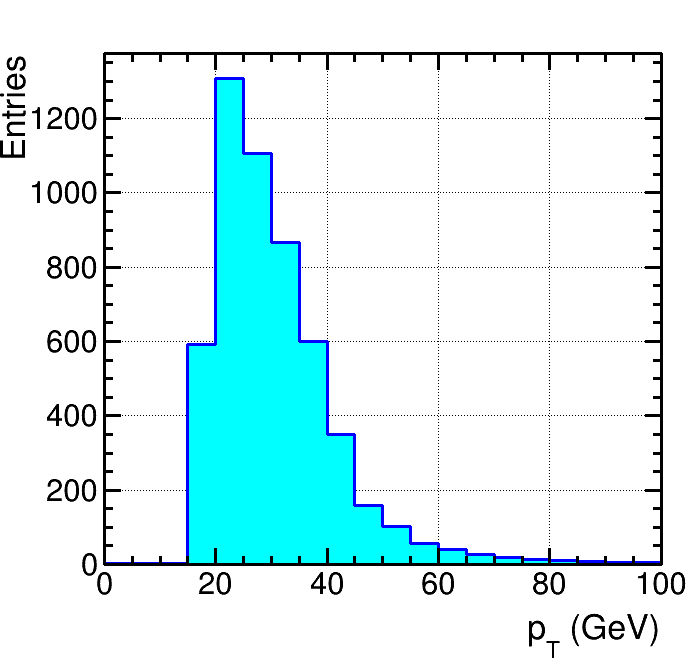

In [32]:
# # The trees can be investigated in this Jupyter notebook:
cv = ROOT.TCanvas()
cv.SetFillColor(0)  # Set canvas background color

tau_tree.Draw('tau_pt>>h(20,0,100)', 'tau_pt > 0.') # only draw if tau was actually reconstructed
#tau_tree.Draw('tau_pt>>h(10,0,100)')

h = ROOT.gROOT.FindObject("h")
h.SetLineColor(ROOT.kBlue)  # Set line color for histogram
h.SetFillColor(ROOT.kCyan)  # Set fill color for histogram
h.SetLineWidth(3)  # Set line width for histogram

h.SetTitle("")
h.GetXaxis().SetTitle("p_{T} (GeV)")  # Set x-axis label
h.GetYaxis().SetTitle("Entries")  # Set y-axis label
h.GetYaxis().SetTitleOffset(1.5)
cv.Draw()


# # Alternatively, to inspect the file, type t = ROOT.TBrowser() in an interactive ROOT 
# # session or "rootbrowse <filename>" in a shell

In the following, we define a base selection that we want all reconstructed taus to pass. We generally want to distinguish true reconstructed taus that pass some kinematic criteria from those coming from jets or leptons.

**Requirements on**:
* Pass decay mode finding
* Pass minimum pT threshold
* Pass max abosulute eta threshold 
* Not reconstructed as DM 5 or DM 6 (less well commissioned than the other decay modes and since the charge assignment has a larger uncertainty)


<div class="alert alert-block alert-warning"> 
<b>Feel free to change the selection criteria and check how the results below change, e.g. if you're interested in high pT taus or in the additional decay modes, etc </b>
</div>

In [33]:
base_selection = 'tau_decayModeFindingNewDMs && tau_pt>20. && abs(tau_eta)<2.3'
base_selection += '&& tau_dm != 5 && tau_dm != 6'

To distinguish taus and jets, different observables are helpful. 

**Isolation Variables**: Look at the sum of the pT values of all particles in a cone around the tau axis that are not used in the tau reconstruction

Since jets have high multiplicity, the isolation values tend to be high for jets while they are small for true taus, where ideally all tau energy was used in the reconstruction of the tau candidate and the only remaining particles in a cone around the tau come from pileup or the underlying event. The simplest observable is the sum of the pT of all charged particles that are compatible with coming from the primary interaction vertex.

Warning in <TFile::Append>: Replacing existing TH1: h_signal (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_bkg (Potential memory leak).


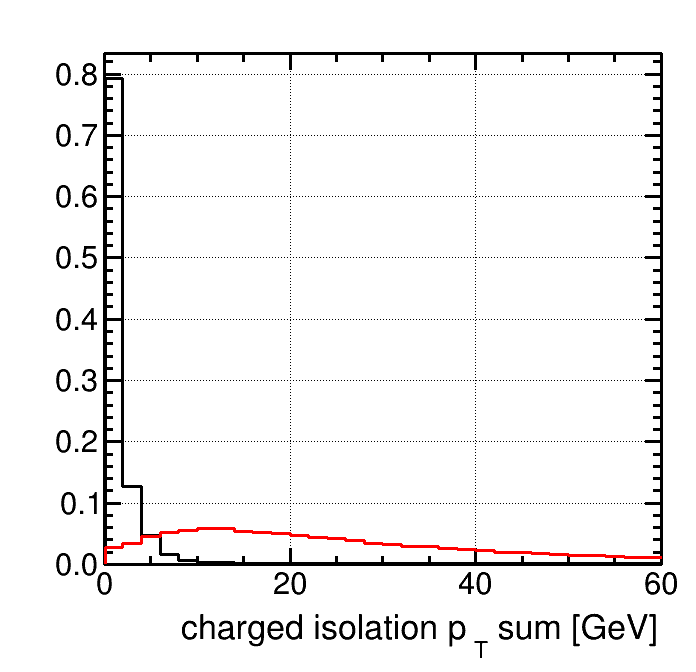

In [45]:
cv = ROOT.TCanvas()
h_signal = ROOT.TH1F('h_signal', '', 30, 0., 60.)
tau_tree.Project('h_signal', 'tau_chargedIsoPtSum', base_selection)
h_bkg = ROOT.TH1F('h_bkg', '', 30, 0., 60.)
jet_tree.Project('h_bkg', 'tau_chargedIsoPtSum', base_selection)

h_signal.GetXaxis().SetTitle('charged isolation p_{T} sum [GeV]')
h_signal.DrawNormalized()
h_signal.SetMinimum(0)  # Set the minimum value for the y-axis to ensure the x-axis label is visible
h_signal.GetXaxis().SetTitle('charged isolation p_{T} sum [GeV]')
h_bkg.SetLineColor(2)
h_bkg.DrawNormalized("same")
cv.Draw()


<div class="alert alert-block alert-warning"> 

There is apparently good separation between true taus (black curve) and jets (red curve).

<b>Can you find more variables that discrimate between taus and jets?</b>
</div>

In [1]:
#Add your code here

A useful tool to compare the discrimination of different variables that can distinguish taus and jets are so-called ROCs (receiver operating curves) that show the background efficiency vs the signal efficiency. Well-performing discriminators are very off-diagonal.

To construct a ROC, we make use of ROOT histograms for a pre-partioning of the data. While not strictly needed, it can be useful to restrict the values in the histograms to be between 0 and 1, so we transform the variables via
`x -> 1/(1+x)` (since x is positive).

In [46]:
signal = ROOT.TH1F('signal', '', 1000, 0., 1.0001)
background = ROOT.TH1F('background', '', 1000, 0., 1.0001)

tau_tree.Project('signal', '1./(1.+tau_chargedIsoPtSum)', base_selection)
jet_tree.Project('background', '1./(1.+tau_chargedIsoPtSum)', base_selection)

43847

The imported functions create a TGraph from the signal and background histograms and subsequently plot the ROC. As can be seen below, the plotting can handle multiple ROCs.

In [52]:
roc = hists_to_roc(signal, background)
roc.title = 'charged'

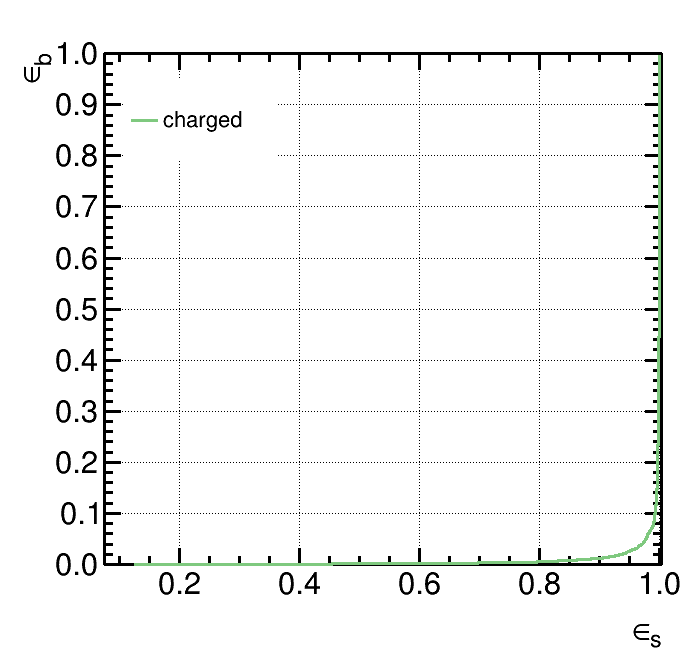

In [53]:
_, canvas = make_roc_plot([roc])
canvas.Draw()


<div class="alert alert-block alert-warning"> 
Now that we've understood how to draw a ROC curve for a single variable, let's try to compare the performance of different tau discriminators against jets.

<b>Which of the discriminants performs best? Are there any drawbacks of the BDT-based or of the DeepTau discrimants?</b>
</div>

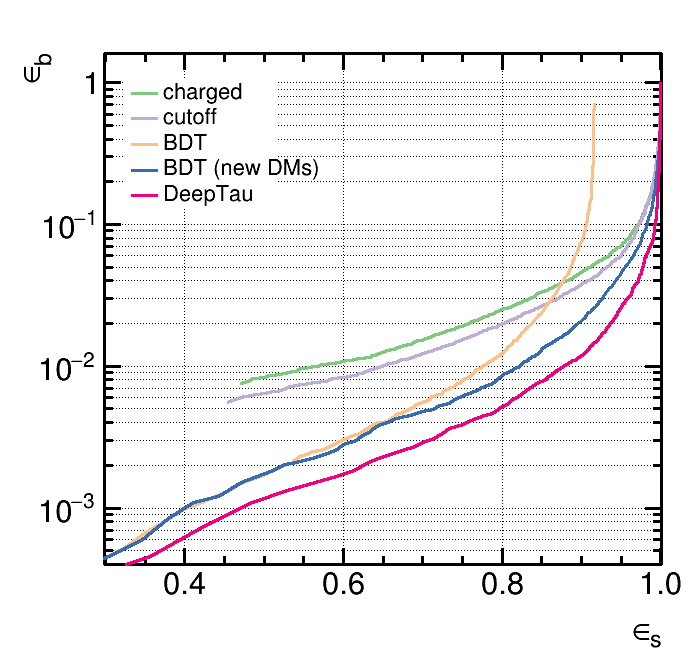

In [54]:
discriminators = {
    'tau_chargedIsoPtSum':'charged', 
    # cutoff-based tau isolation, used in run 1, e.g. in TAU-14-001 and HIG-13-004
    'tau_byCombinedIsolationDeltaBetaCorrRaw3Hits':'cutoff', 
    # BDT-based tau ID, started in TAU-14-001 and refined in TAU-16-003
    'tau_byIsolationMVArun2v1DBoldDMwLTraw':'BDT', 
    # BDT-based tau ID, started in TAU-14-001 and refined in TAU-16-003
    'tau_byIsolationMVArun2v1DBnewDMwLTraw':'BDT (new DMs)', 
    # New DNN-based ID
    'tau_byDeepTau2017v2VSjetraw':'DeepTau'
}
rocs = []
for disc, title in discriminators.items():
    s_name = 'signal'+disc
    b_name = 'background'+disc
    signal = ROOT.TH1F(s_name, '', 1000, 0., 1.0001)
    background = ROOT.TH1F(b_name, '', 1000, 0., 1.0001)
    # The BDT values lie in the range [-1, 1] so we transform x -> 1./(2+x)
    # to make sure outputs lie in the range [0, 1]
    tau_tree.Project(s_name, f'1./(2.+{disc})', base_selection)
    jet_tree.Project(b_name, f'1./(2.+{disc})', base_selection)
    roc = hists_to_roc(signal, background)
    roc.title = title
    rocs.append(roc)
_, m_canvas = make_roc_plot(rocs, xmin=0.3, ymin=0.0001, ymax=0., logy=True)
m_canvas.Draw()
    

<div class="alert alert-block alert-warning"> 
Finally, tau identification is not only about discriminating against jets but also against electrons and muons.

* Which observables might help to distinguish taus from electrons or muons?
* Can you try to create similar ROCs as above but for the discrimination of taus against electrons or muons?

Hints:
* Use the trees created in the following cells that contain taus either coming from true muons (Z$\rightarrow$$\mu\mu$) or true electrons (Z$\rightarrow$ee)
* As before, there are different discriminators: __tau_againstElectronMVA6Raw__, __tau_byDeepTau2017v2VSeraw__, __tau_byDeepTau2017v2VSmuraw__
</div>

In [57]:
mu_sample = f'{base_dir}/zmm_10_6_14.root'
mu_file = ROOT.TFile.Open(mu_sample)
mu_tree = mu_file.Get('per_tau')

ele_sample = f'{base_dir}/zee_10_6_14.root'
ele_file = ROOT.TFile.Open(ele_sample)
ele_tree = ele_file.Get('per_tau')

In [3]:
# Add your code here for electrons

In [2]:
# Add your code here for muons

Congratulations if you made it this far! It would be great if you could share with the facilitators that you finished the exercises and ideally also your final jupyter notebooks. The final notebooks can be shared in the format you prefer, e.g. by putting them into a github repository, exporting the notebook as html/pdf/..., or by other means.